In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer

import plotly.express as px
import plotly.graph_objects as go

import os
import re 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

sns.set()

C:\Users\dinar\AppData\Local\Temp\ipykernel_10984\765240082.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def show_plot(df, pred='preds'):
    agg_data = df.copy()
    agg_data.pricing_date = pd.to_datetime(agg_data.pricing_date)
    agg_data.forecast_date = agg_data.forecast_date.astype(str)

    agg_data = agg_data.set_index('pricing_date')

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    fig = px.line(df, x=df.index, y=pred, color='forecast_date', markers=True, height=600, width=1200)
    fig.update_traces(opacity=0.5, line=dict(width=2, ))

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    x = df.index
    y = df['target']
    name = 'target'
    fig.add_trace(
        go.Scatter(x=x, y=y, name=name, mode='lines+markers', opacity=0.5, marker=dict(color='darkgray', size=10),
                   line=dict(width=18, color='gray')))  # ,shape = 'hv'
    fig.show()
    

def show_results(results, save_path):
    thresh = 0.2

    results['nth_day'] = results.groupby('forecast_date')['preds'].cumcount()
    results['preds_diff'] = results.groupby('forecast_date')['preds'].diff()
    results['traget_diff'] = results.groupby('forecast_date')['target'].diff()
    results['preds_diff_cum'] = results.groupby('forecast_date')['preds_diff'].cumsum()
    results['traget_diff_cum'] = results.groupby('forecast_date')['traget_diff'].cumsum()
    results['preds_direct'] = results['preds_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['traget_direct'] = results['traget_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['preds_direct_cum'] = results['preds_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['traget_direct_cum'] = results['traget_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['pnl_stra_daily_direct'] = results['preds_direct'] * results['traget_diff']
    results['pnl_stra_cum_direct'] = results['preds_direct_cum'] * results['traget_diff_cum']

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    results.pivot_table(index='pricing_date', values='pnl_stra_cum_direct', aggfunc=sum).cumsum().plot(ax=ax[0],
                                                                                                       title='pnl_stra_cum_direct')
    results.pivot_table(index='pricing_date', values='pnl_stra_daily_direct', aggfunc=sum).cumsum().plot(ax=ax[1],
                                                                                                         title='pnl_stra_daily_direct')
    fig.show()

In [3]:
def get_data(path, test_start, test_end, target='F380 M2/M3'):
    data = pd.read_csv(path)
    data.pricing_date = pd.to_datetime(data.pricing_date)
    data.set_index('pricing_date', inplace=True)
    data.interpolate('linear', inplace=True)
    
    # slice the dataset
    data = data[data.index < test_end]
    return data

In [4]:
data = get_data('../data/data_2024-02-02.csv', '2023-01-01', '2024-01-01')
data

,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,CAOSG,...,_rgp_03_sz_3,_rgp_04_sz_3,_rgp_05_sz_3,_rgp_06_sz_3,_rgp_07_sz_3,_rgp_08_sz_3,_rgp_09_sz_3,_rgp_10_sz_3,_rgp_11_sz_3,F380 M2/M3
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.500
2017-01-11,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.300
2017-01-12,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,530.000000,0.000000,920.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.700
2017-01-13,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,1060.000000,0.000000,615.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.850
2017-01-16,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,1060.000000,0.000000,3.333333,0.0,0.0,0.0,0.000000,0.0,0.0,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,0.0,0.0,0.0,0.0,0.0,2.300491,0.0,0.0,0.0,0.0,...,-1075.888889,1741.777778,0.000000,0.0,0.0,0.0,1017.888889,0.0,0.0,3.225
2023-12-26,0.0,0.0,0.0,0.0,0.0,2.404817,0.0,0.0,0.0,0.0,...,-1313.944444,761.777778,0.000000,0.0,0.0,0.0,991.222222,0.0,0.0,2.950
2023-12-27,0.0,0.0,0.0,0.0,0.0,2.791667,0.0,0.0,0.0,0.0,...,-1749.500000,408.444444,-93.333333,0.0,0.0,0.0,1224.555556,0.0,0.0,3.150


In [14]:
target_col = 'F380 M2/M3'

targets = data[[target_col]]
targets = targets.merge(targets.shift([1, 3, 5, 10]), on='pricing_date')
targets

,F380 M2/M3,F380 M2/M3_1,F380 M2/M3_3,F380 M2/M3_5,F380 M2/M3_10
pricing_date,,,,,
2017-01-10,1.500,NaN,NaN,NaN,NaN
2017-01-11,1.300,1.500,NaN,NaN,NaN
2017-01-12,1.700,1.300,NaN,NaN,NaN
2017-01-13,1.850,1.700,1.500,NaN,NaN
2017-01-16,2.000,1.850,1.300,NaN,NaN
...,...,...,...,...,...
2023-12-25,3.225,3.500,2.750,2.75,2.50
2023-12-26,2.950,3.225,2.850,2.75,2.30
2023-12-27,3.150,2.950,3.500,2.75,2.25


In [15]:
targets.dropna(inplace=True)

In [16]:
targets

,F380 M2/M3,F380 M2/M3_1,F380 M2/M3_3,F380 M2/M3_5,F380 M2/M3_10
pricing_date,,,,,
2017-01-24,0.800,1.200,1.200,1.65,1.50
2017-01-25,0.150,0.800,0.850,1.45,1.30
2017-01-26,0.150,0.150,1.200,1.20,1.70
2017-01-27,0.200,0.150,0.800,0.85,1.85
2017-01-30,-0.275,0.200,0.150,1.20,2.00
...,...,...,...,...,...
2023-12-25,3.225,3.500,2.750,2.75,2.50
2023-12-26,2.950,3.225,2.850,2.75,2.30
2023-12-27,3.150,2.950,3.500,2.75,2.25


In [17]:
# data = data[data.index.isin(targets.index)]
data.drop(columns=target_col, inplace=True)

# Predict using no new features except for time-related

In [19]:
df = data.copy()
df['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
df['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
df['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
df['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)


df['year_num'] = data.index.year
df['month_num'] = data.index.month
df['day_num'] = data.index.day
df['dow_num'] = data.index.dayofweek
df

,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,CAOSG,...,_rgp_10_sz_3,_rgp_11_sz_3,year_sin,month_sin,day_sin,dow_sin,year_num,month_num,day_num,dow_num
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.863417e-02,5.000000e-01,0.897805,1.000000e+00,2017,1,10,1
2017-01-11,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.863417e-02,5.000000e-01,0.790776,1.224647e-16,2017,1,11,2
2017-01-12,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.863417e-02,5.000000e-01,0.651372,-1.000000e+00,2017,1,12,3
2017-01-13,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.863417e-02,5.000000e-01,0.485302,-2.449294e-16,2017,1,13,4
2017-01-16,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.863417e-02,5.000000e-01,-0.101168,0.000000e+00,2017,1,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,0.0,0.0,0.0,0.0,0.0,2.300491,0.0,0.0,0.0,0.0,...,0.0,0.0,-2.449294e-16,-2.449294e-16,-0.937752,0.000000e+00,2023,12,25,0
2023-12-26,0.0,0.0,0.0,0.0,0.0,2.404817,0.0,0.0,0.0,0.0,...,0.0,0.0,-2.449294e-16,-2.449294e-16,-0.848644,1.000000e+00,2023,12,26,1
2023-12-27,0.0,0.0,0.0,0.0,0.0,2.791667,0.0,0.0,0.0,0.0,...,0.0,0.0,-2.449294e-16,-2.449294e-16,-0.724793,1.224647e-16,2023,12,27,2


In [24]:
df = df[df.index.isin(targets.index)]
df

,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,CAOSG,...,_rgp_10_sz_3,_rgp_11_sz_3,year_sin,month_sin,day_sin,dow_sin,year_num,month_num,day_num,dow_num
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-24,0.0,0.0,0.0,0.0,0.0,6.569996,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.863417e-02,5.000000e-01,-0.988468,1.000000e+00,2017,1,24,1
2017-01-25,0.0,0.0,0.0,0.0,0.0,5.642896,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.863417e-02,5.000000e-01,-0.937752,1.224647e-16,2017,1,25,2
2017-01-26,0.0,0.0,0.0,0.0,0.0,6.052765,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.863417e-02,5.000000e-01,-0.848644,-1.000000e+00,2017,1,26,3
2017-01-27,0.0,0.0,0.0,0.0,0.0,6.464088,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.863417e-02,5.000000e-01,-0.724793,-2.449294e-16,2017,1,27,4
2017-01-30,0.0,0.0,0.0,0.0,0.0,6.787383,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.863417e-02,5.000000e-01,-0.201299,0.000000e+00,2017,1,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,0.0,0.0,0.0,0.0,0.0,2.300491,0.0,0.0,0.0,0.0,...,0.0,0.0,-2.449294e-16,-2.449294e-16,-0.937752,0.000000e+00,2023,12,25,0
2023-12-26,0.0,0.0,0.0,0.0,0.0,2.404817,0.0,0.0,0.0,0.0,...,0.0,0.0,-2.449294e-16,-2.449294e-16,-0.848644,1.000000e+00,2023,12,26,1
2023-12-27,0.0,0.0,0.0,0.0,0.0,2.791667,0.0,0.0,0.0,0.0,...,0.0,0.0,-2.449294e-16,-2.449294e-16,-0.724793,1.224647e-16,2023,12,27,2


In [22]:
import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

In [25]:
X_train, X_test, y_train, y_test = df.loc[:'2023-01-01', :], df.loc['2023-01-01':], targets.loc[:'2023-01-01'], targets.loc['2023-01-01':]


In [26]:
lasso = MultiOutputRegressor(Lasso(random_state=15, max_iter=500000))
lasso.fit(X_train, y_train)

MultiOutputRegressor(estimator=Lasso(max_iter=500000, random_state=15))

In [27]:
# Make predictions

preds = lasso.predict(X_train)

# The predictions are made for each one of
# the targets.

preds.shape

(1549, 5)

In [28]:
# Let's capture the predictions in a dataframe
# to determine the RMSE and plot the results.

preds = pd.DataFrame(preds, columns=y_train.columns)

preds.head()

,F380 M2/M3,F380 M2/M3_1,F380 M2/M3_3,F380 M2/M3_5,F380 M2/M3_10
0,0.492714,0.501603,0.594020,0.939309,1.298290
1,1.865151,1.801993,1.772354,2.087608,2.571378
2,1.279917,1.294722,1.387243,1.666769,1.829722
3,0.639768,0.609799,0.661981,1.070522,1.390846
4,-1.832991,-1.683068,-1.524228,-1.234870,-1.011214


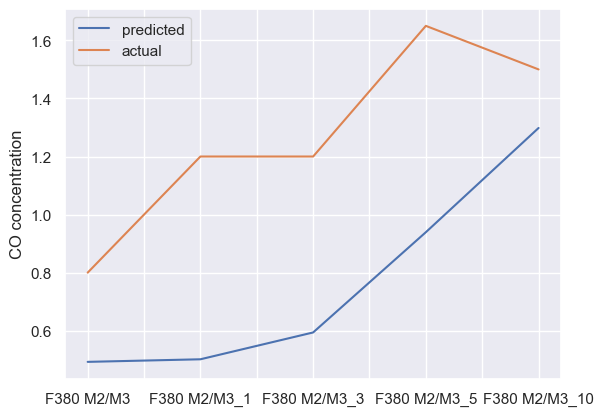

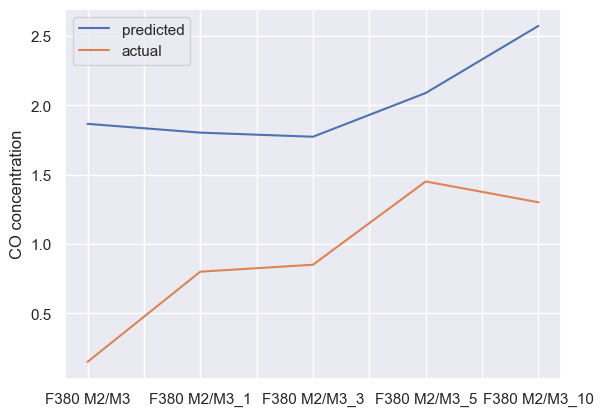

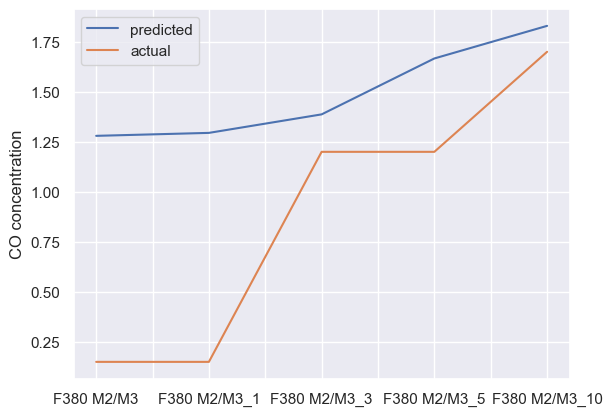

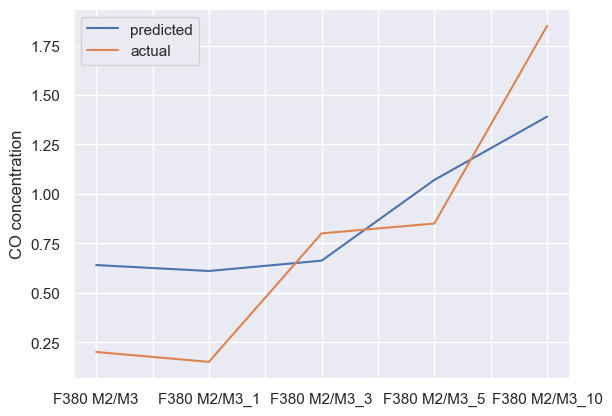

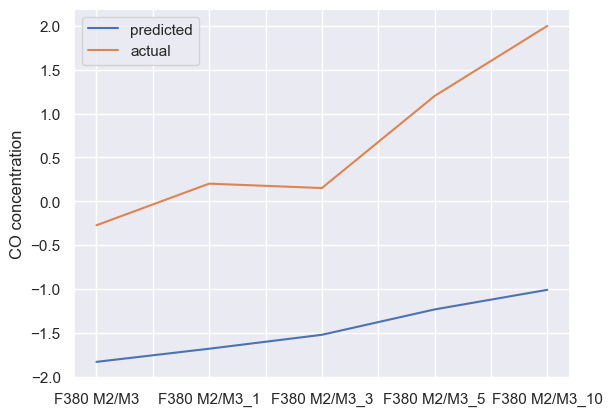

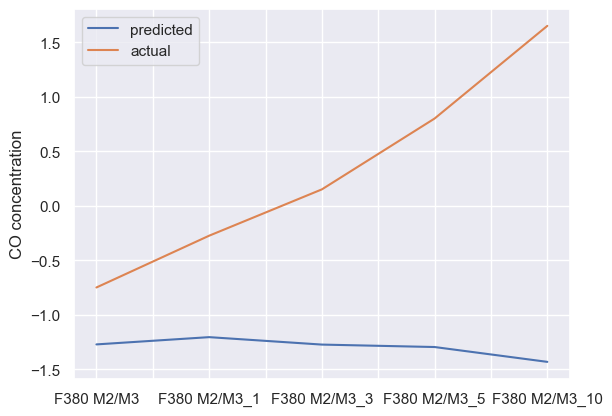

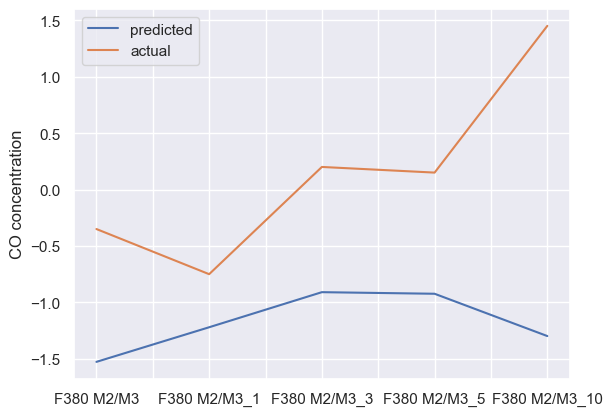

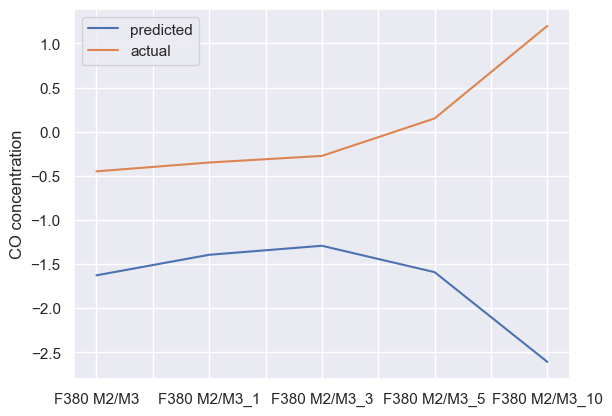

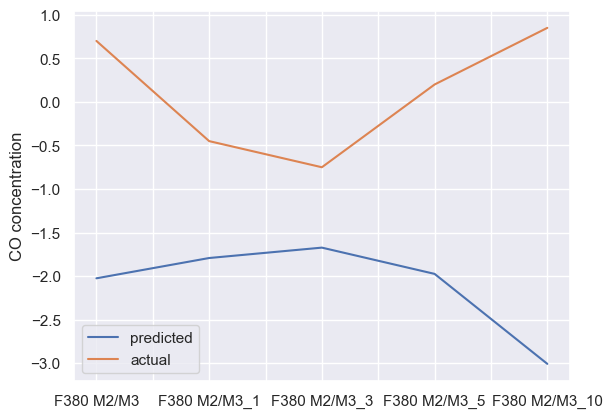

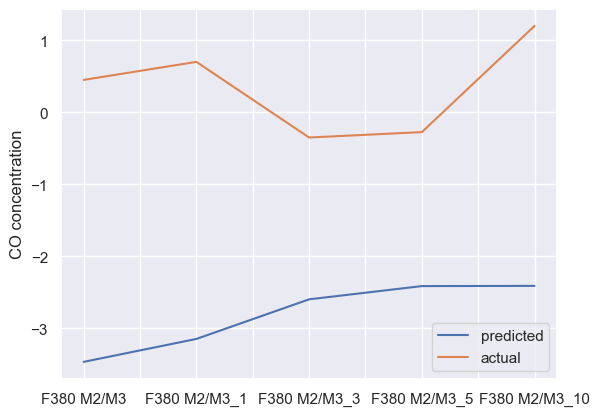

In [29]:
# Each row corresponds to 24 hr forecasts.

for i in range(0, 10):
    tmp = pd.concat(
        [
            preds.iloc[i].T,
            y_train.iloc[i].T,
        ],
        axis=1,
    )

    tmp.columns = ["predicted", "actual"]

    tmp.plot()
    plt.ylabel("CO concentration")
    plt.show()

In [34]:
y_train

,F380 M2/M3,F380 M2/M3_1,F380 M2/M3_3,F380 M2/M3_5,F380 M2/M3_10
pricing_date,,,,,
2017-01-24,0.800,1.200,1.200,1.65,1.50
2017-01-25,0.150,0.800,0.850,1.45,1.30
2017-01-26,0.150,0.150,1.200,1.20,1.70
2017-01-27,0.200,0.150,0.800,0.85,1.85
2017-01-30,-0.275,0.200,0.150,1.20,2.00
...,...,...,...,...,...
2022-12-26,1.375,1.750,-0.250,-1.50,-2.25
2022-12-27,1.000,1.375,1.000,-0.50,-2.50
2022-12-28,1.250,1.000,1.750,-0.25,-1.45


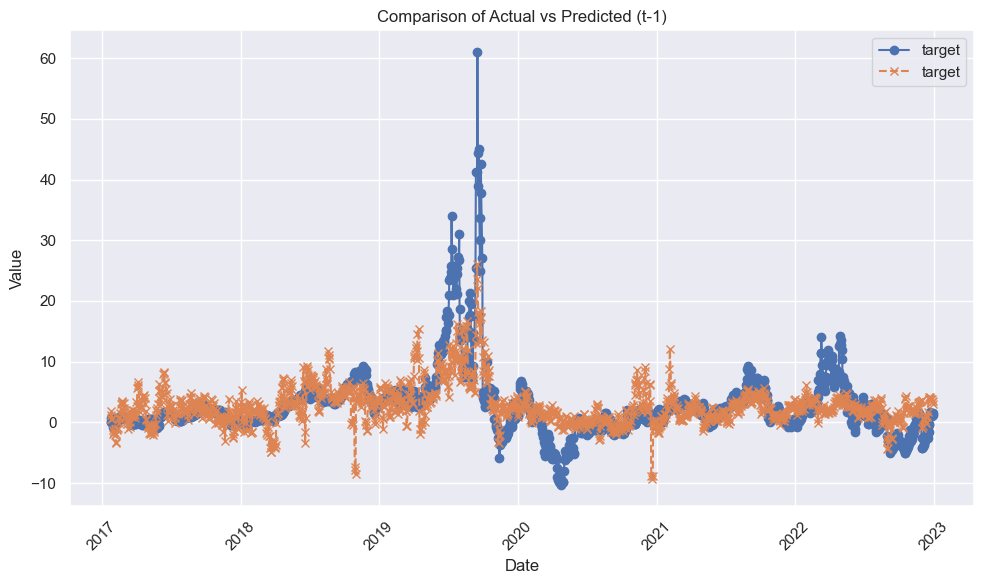

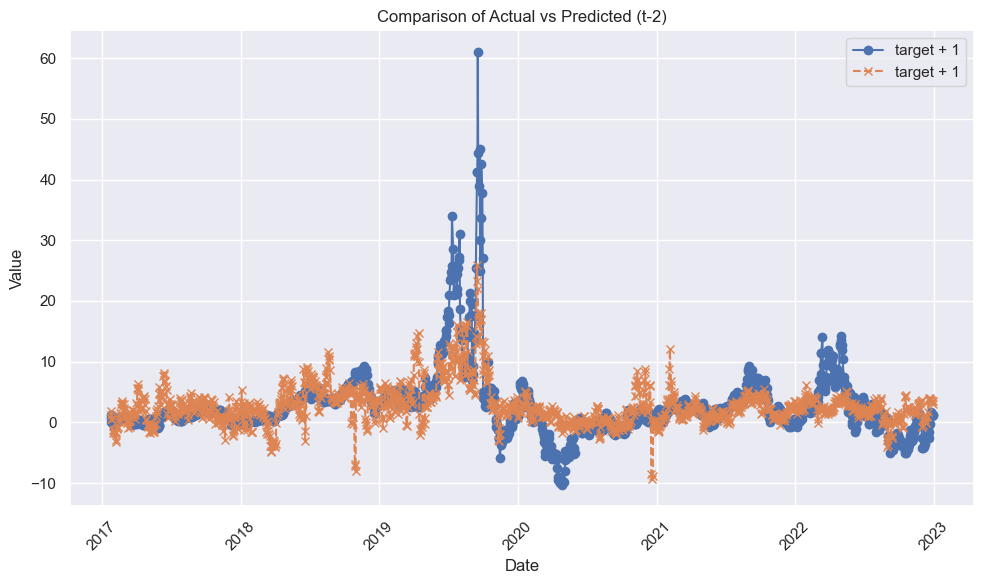

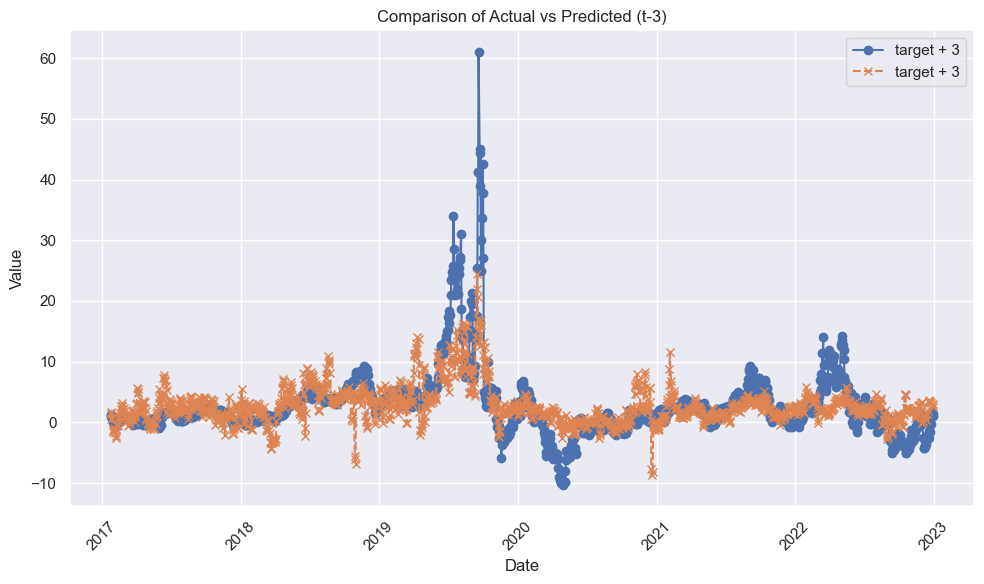

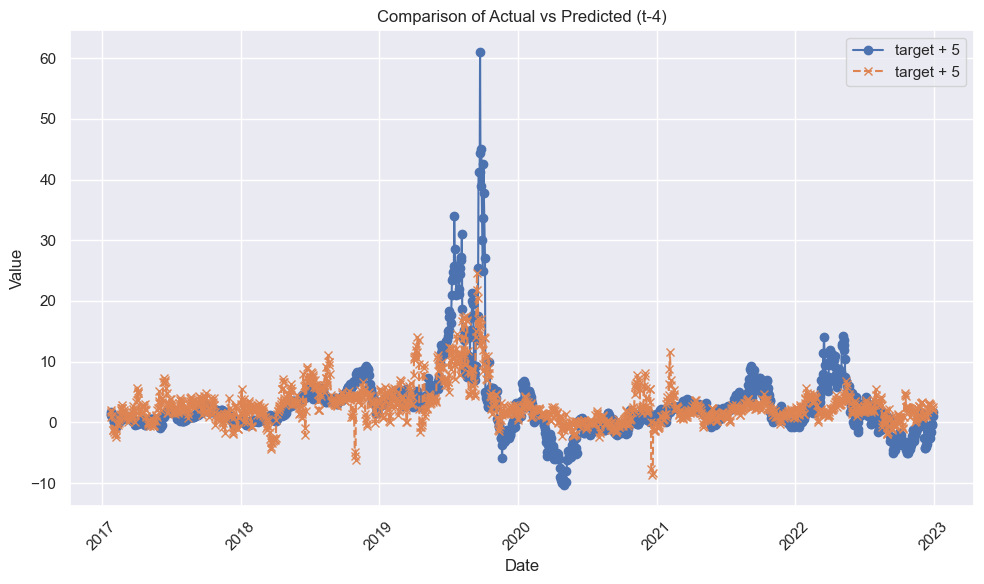

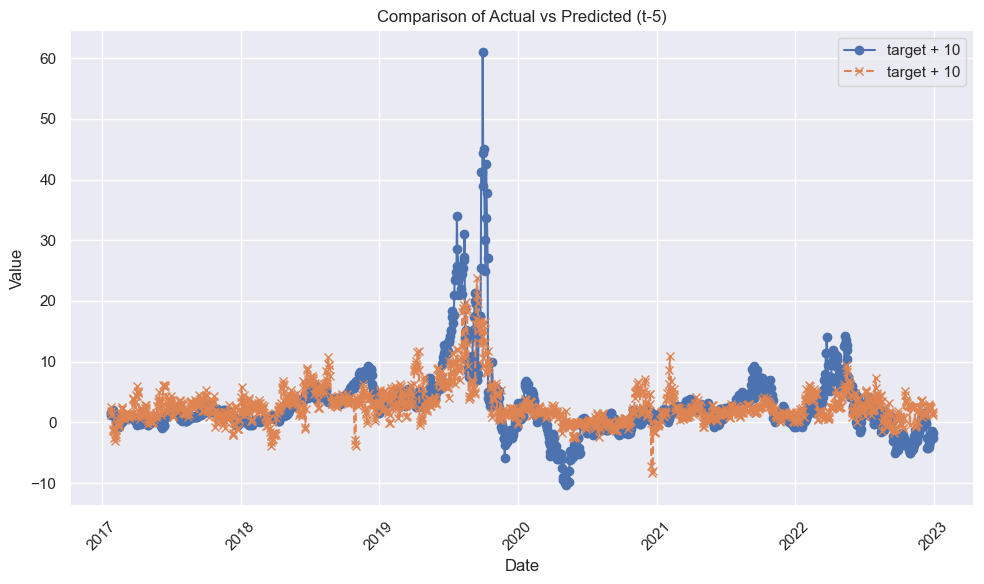

In [35]:
# Plotting
num_time_steps = len(y_test.columns)

cols = ['target', 'target + 1', 'target + 3', 'target + 5', 'target + 10']

for t in range(num_time_steps):
    plt.figure(figsize=(10, 6))
    plt.plot(y_train.iloc[:, t], label=cols[t], marker='o')
    plt.plot(y_train.index, preds.iloc[:, t], label=cols[t], linestyle='dashed', marker='x')
    plt.title(f'Comparison of Actual vs Predicted (t-{t+1})')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [36]:
# Let's capture the predictions in a dataframe
# to determine the RMSE and plot the results.
preds = lasso.predict(X_test)

preds = pd.DataFrame(preds, columns=y_test.columns)

preds.head()

,F380 M2/M3,F380 M2/M3_1,F380 M2/M3_3,F380 M2/M3_5,F380 M2/M3_10
0,1.829946,2.013525,2.219037,1.965148,1.938297
1,1.554240,1.721321,1.916444,1.655505,1.633146
2,1.515240,1.657378,1.853261,1.600595,1.674194
3,1.832544,1.934548,2.021368,1.699876,1.577311
4,2.542939,2.609057,2.595216,2.211456,1.911353


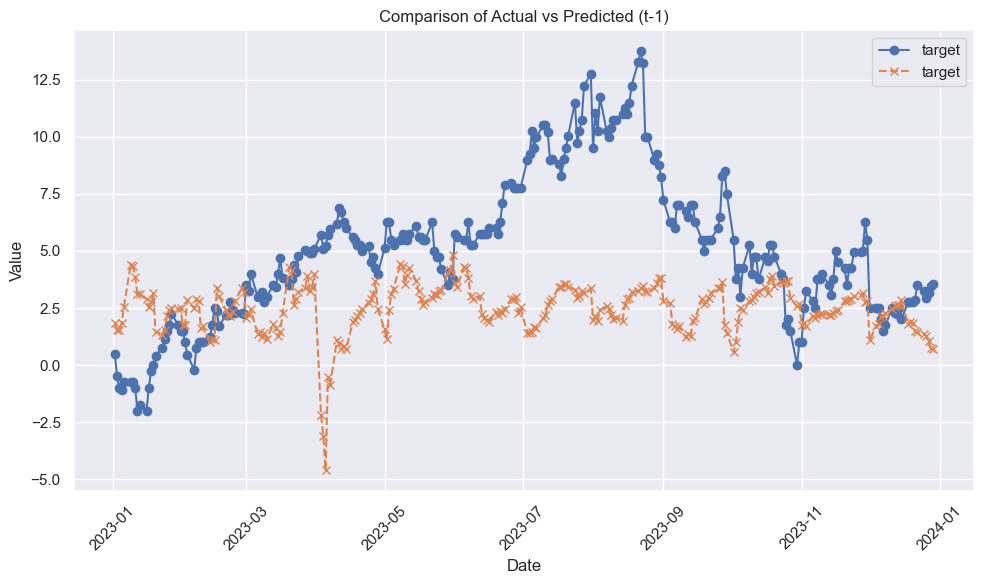

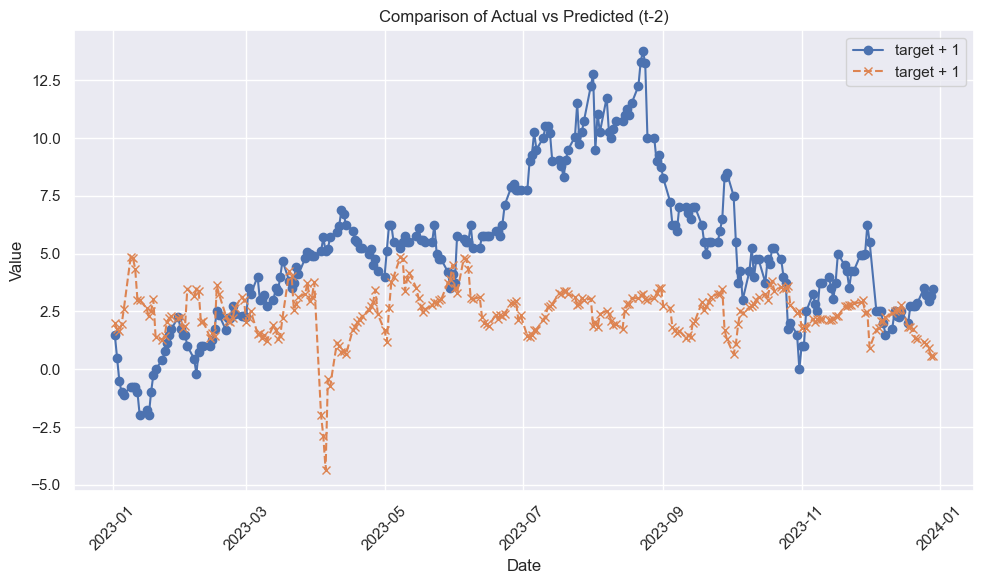

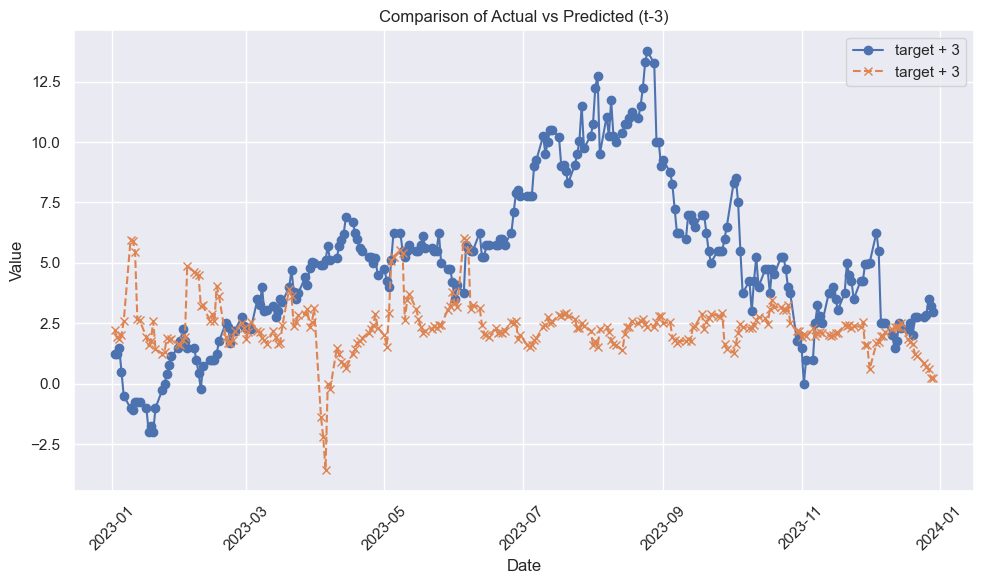

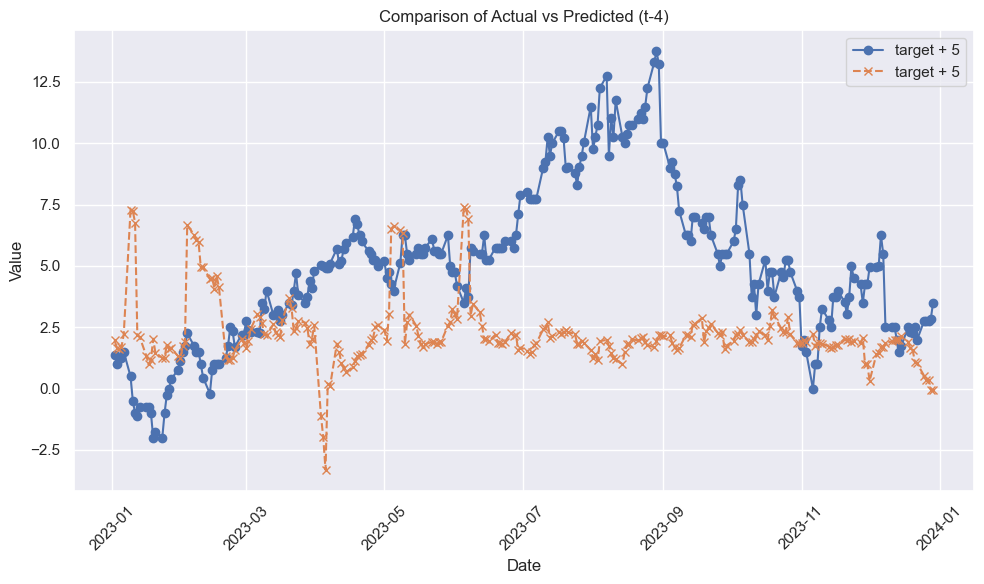

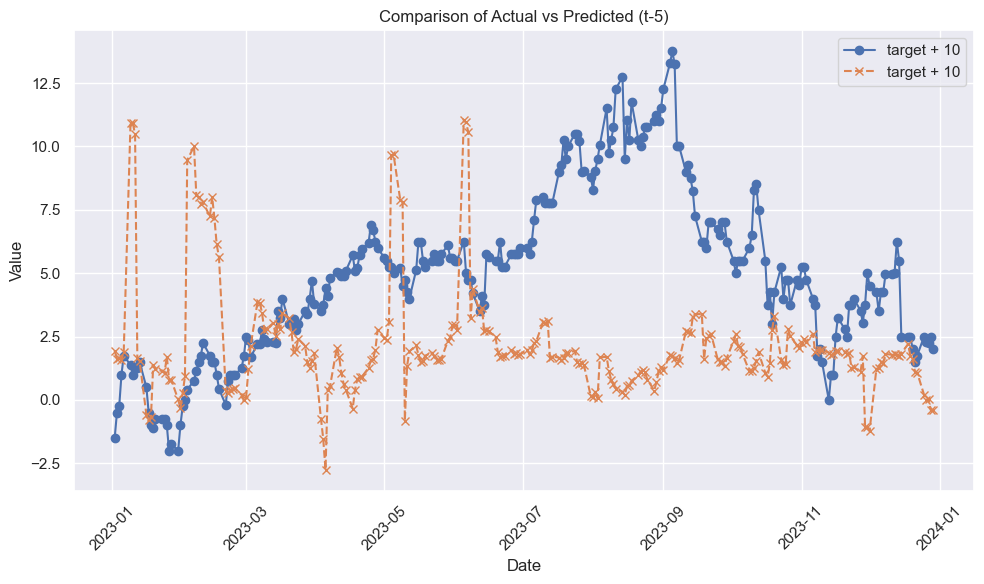

In [37]:
# Plotting
num_time_steps = len(y_test.columns)

cols = ['target', 'target + 1', 'target + 3', 'target + 5', 'target + 10']

for t in range(num_time_steps):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.iloc[:, t], label=cols[t], marker='o')
    plt.plot(y_test.index, preds.iloc[:, t], label=cols[t], linestyle='dashed', marker='x')
    plt.title(f'Comparison of Actual vs Predicted (t-{t+1})')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Normalize data

In [43]:
def predict(data, targets, test_start, normalize=False):
    X_train, X_test = data[data.index < test_start], data[data.index >= test_start]
    y_train, y_test = targets[targets.index < test_start], targets[targets.index >= test_start]
    
    if normalize:
        scaler = MinMaxScaler().fit(X_train)
        X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
        
        scaler = MinMaxScaler().fit(y_train)
        y_train = pd.DataFrame(scaler.transform(y_train), columns=y_train.columns, index=y_train.index)
        y_test = pd.DataFrame(scaler.transform(y_test), columns=y_test.columns, index=y_test.index)
        
    lasso = MultiOutputRegressor(Lasso(random_state=15, max_iter=500000))
    lasso.fit(X_train, y_train)
    
    preds = lasso.predict(X_test)
    preds = pd.DataFrame(preds, columns=y_test.columns, index=y_test.index)
    
    # Plotting
    num_time_steps = len(y_test.columns)

    cols = ['target', 'target + 1', 'target + 3', 'target + 5', 'target + 10']

    for t in range(num_time_steps):
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.iloc[:, t], label=cols[t], marker='o')
        plt.plot(y_test.index, preds.iloc[:, t], label=cols[t], linestyle='dashed', marker='x')
        plt.title(f'Comparison of Actual vs Predicted ({cols[t]})')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

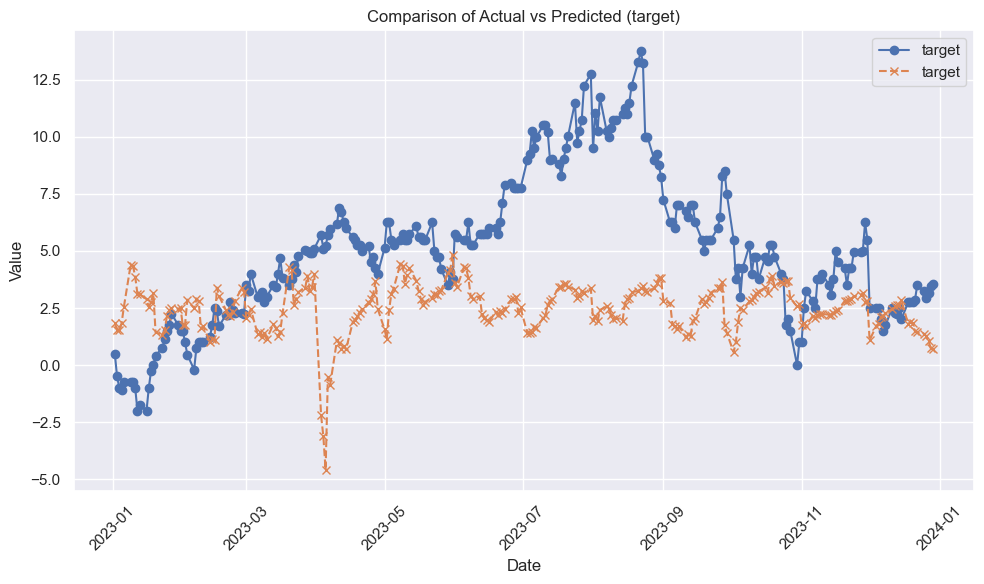

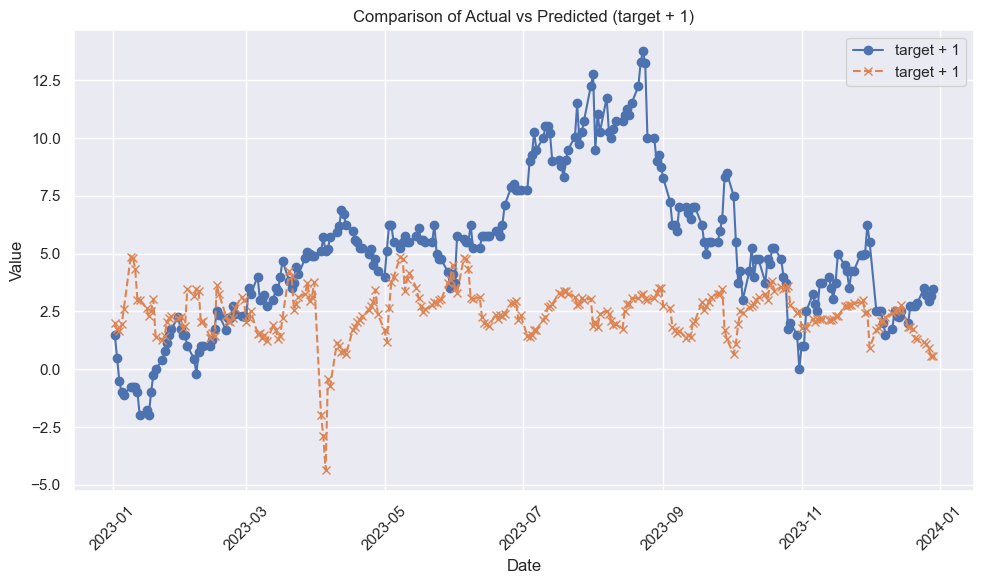

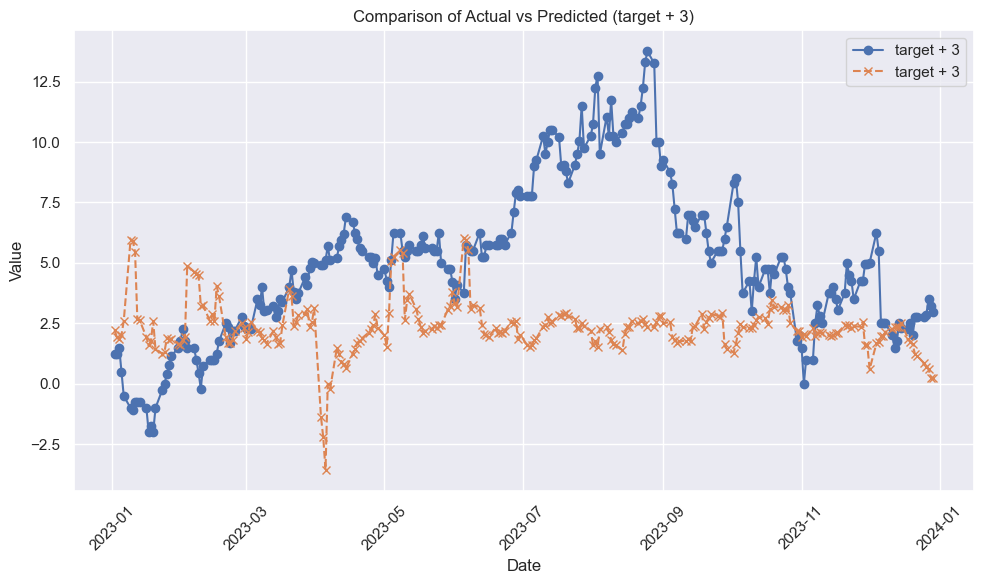

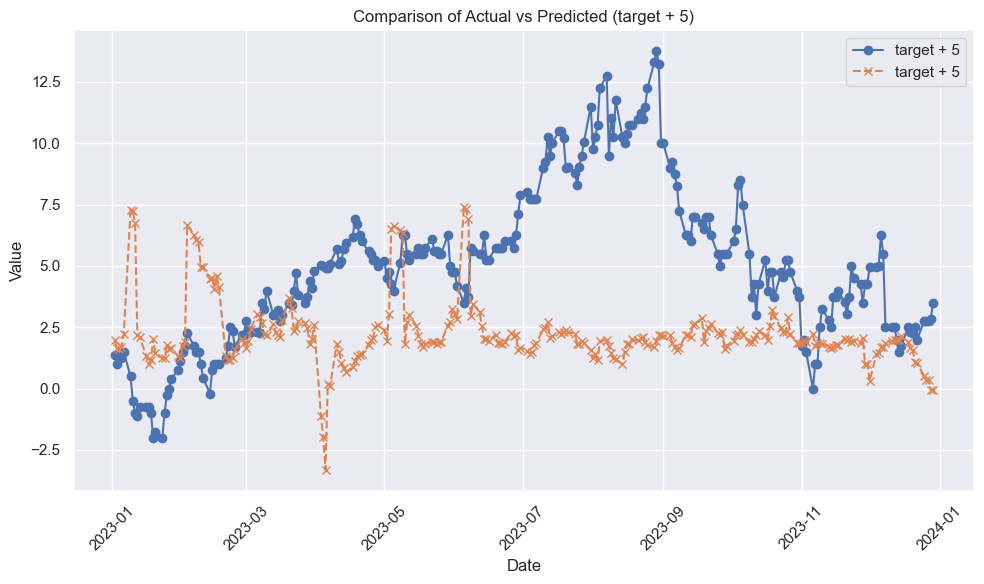

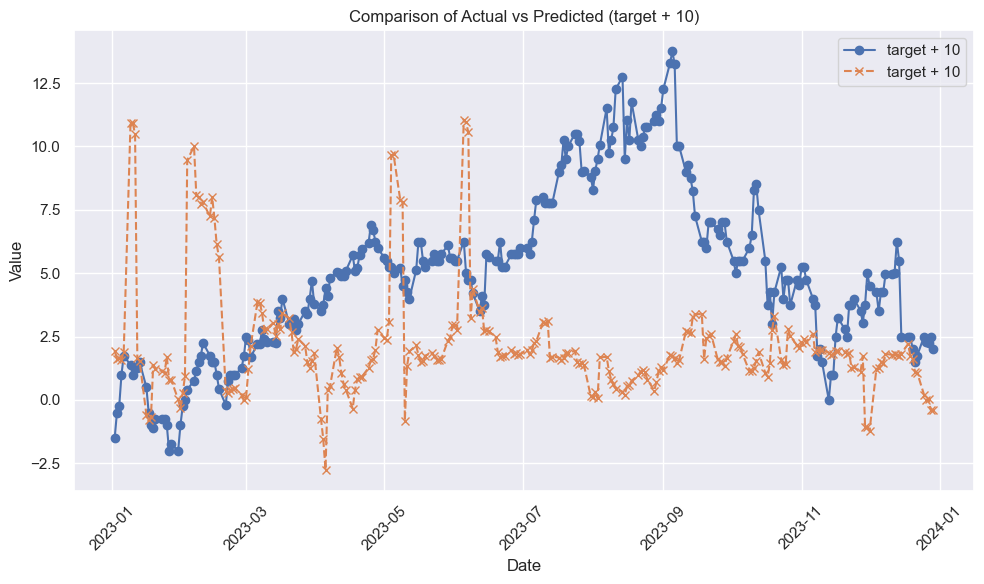

In [44]:
predict(df, targets, '2023-01-01')

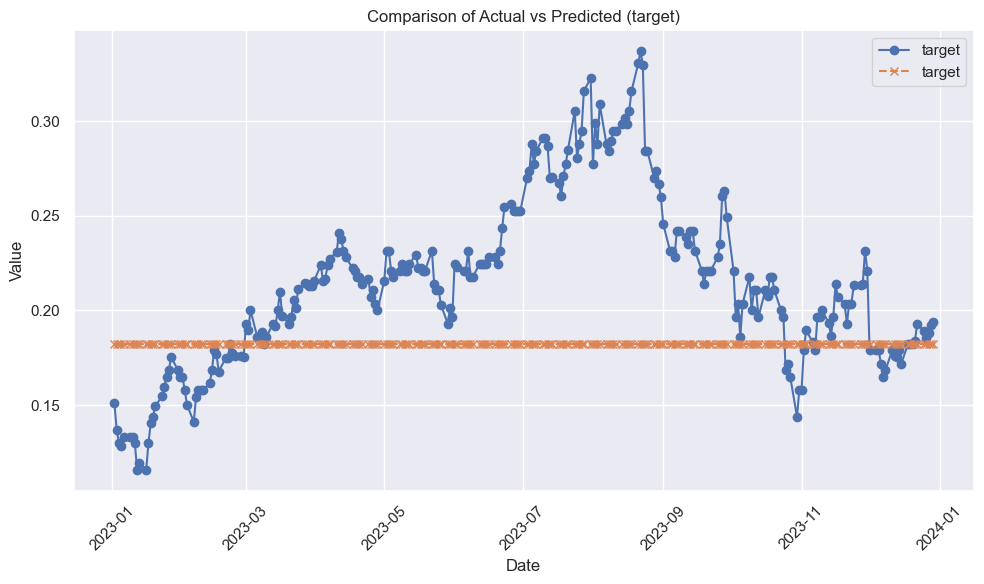

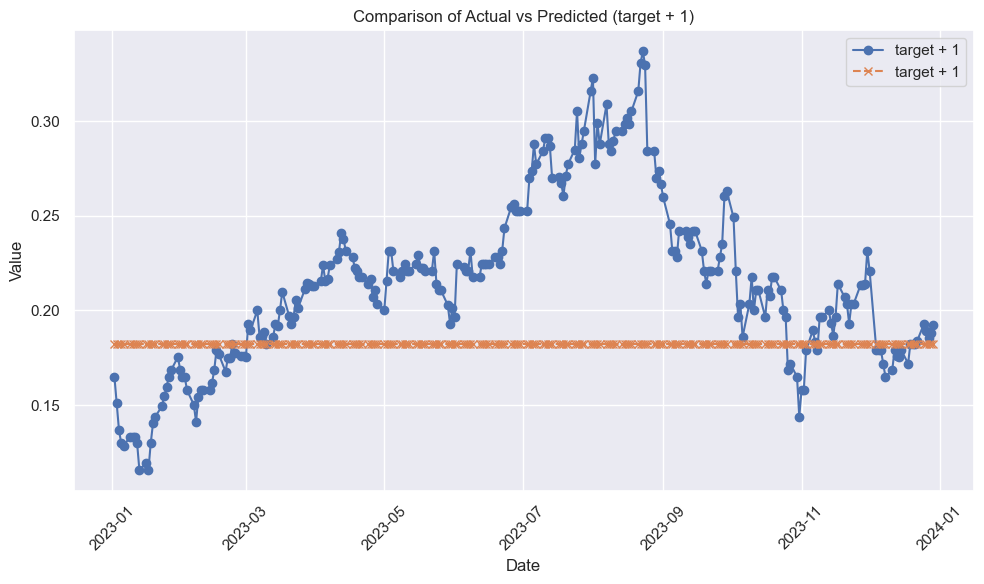

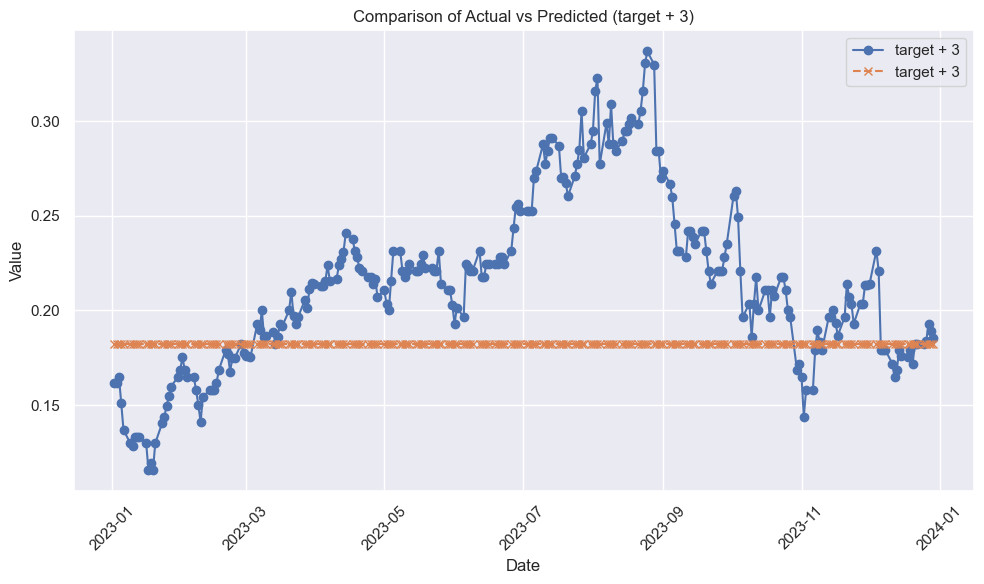

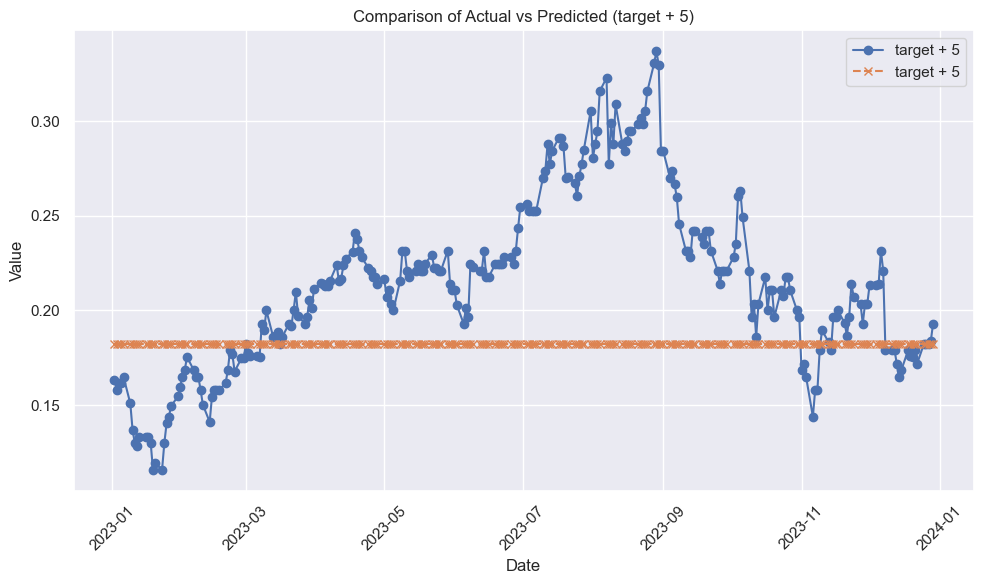

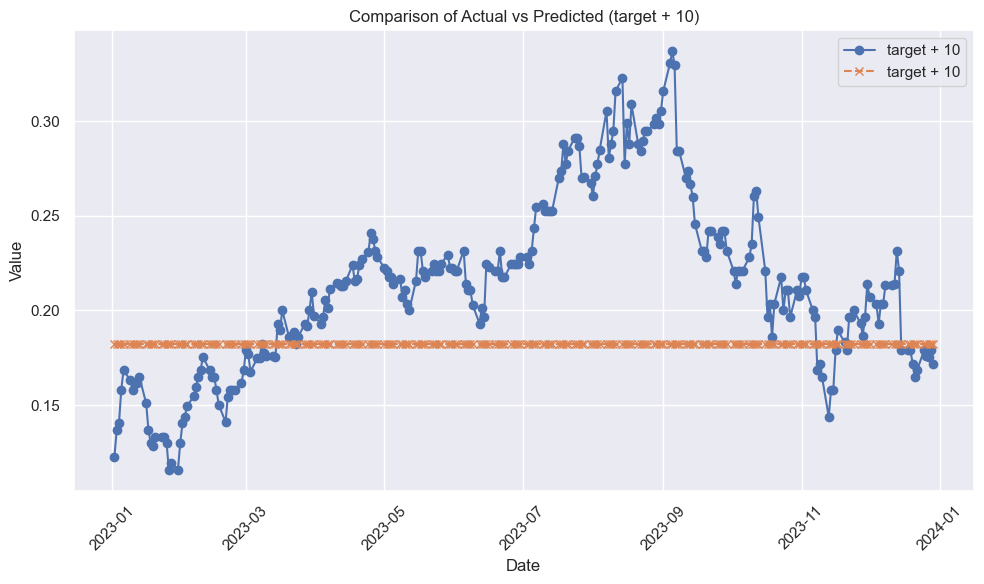

In [45]:
predict(df, targets, '2023-01-01', True)

# Add feature engineering

In [111]:
data = pd.read_csv('../data/data_2024-02-02.csv')
data.drop(columns=target_col, inplace=True)
data.set_index('pricing_date', inplace=True)

In [71]:
def add_columns(data, col):
    shifted = pd.DataFrame(columns=[f'{col}+{x}' for x in [1, 3, 5, 10]], index=data.index)
    # shifted = shifted[::-1]                           # reverse the dataframe
    
    # reversed_data = data.reset_index()[::-1]          # reverse the original df
    
    for i, (idx, row) in enumerate(data[[col]].iterrows()):
        vals = []
        
        for ix in [1, 3, 5, 10]:
            try:
                ixs = i + ix
                # print(ixs)
                
                if ixs > len(data):
                    vals.append(np.nan)
                    # break
                else:
                    val = data.iloc[ixs][col]
                    vals.append(val)
                # print('ix:', ix, 'idx:', idx, 'i:', i, 'ixs:', ixs)
            except IndexError:
                vals.append(np.nan)
            except ZeroDivisionError:
                vals.append(np.nan)
        
        # print(vals, len(vals))
        shifted.iloc[i, :] = vals
    
    
    # reverse back, merge, and remove the first values
    # shifted = shifted.reset_index()[::-1]
    # shifted = shifted.merge(data[target], on='pricing_date')
    # shifted = shifted.iloc[20:, :]
    # shifted.drop(columns=target, inplace=True)
    
    # shifted = shifted[shifted.columns[::-1]]
    # 
    return shifted

In [112]:
new_df = pd.DataFrame(index=data.index)

for col in data.columns:
    new_df = pd.concat([new_df, data[col]], axis=1)
    new_df = pd.concat([new_df, add_columns(data, col)], axis=1)

new_df

,ALVARI,ALVARI+1,ALVARI+3,ALVARI+5,ALVARI+10,ARAMCOSG,ARAMCOSG+1,ARAMCOSG+3,ARAMCOSG+5,ARAMCOSG+10,...,_rgp_10_sz_3,_rgp_10_sz_3+1,_rgp_10_sz_3+3,_rgp_10_sz_3+5,_rgp_10_sz_3+10,_rgp_11_sz_3,_rgp_11_sz_3+1,_rgp_11_sz_3+3,_rgp_11_sz_3+5,_rgp_11_sz_3+10
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN
2024-02-27,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN
2024-02-28,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN


In [78]:
targets

,F380 M2/M3,F380 M2/M3_1,F380 M2/M3_3,F380 M2/M3_5,F380 M2/M3_10
pricing_date,,,,,
2017-01-24,0.800,1.200,1.200,1.65,1.50
2017-01-25,0.150,0.800,0.850,1.45,1.30
2017-01-26,0.150,0.150,1.200,1.20,1.70
2017-01-27,0.200,0.150,0.800,0.85,1.85
2017-01-30,-0.275,0.200,0.150,1.20,2.00
...,...,...,...,...,...
2023-12-25,3.225,3.500,2.750,2.75,2.50
2023-12-26,2.950,3.225,2.850,2.75,2.30
2023-12-27,3.150,2.950,3.500,2.75,2.25


In [84]:
data.loc['2017-01-24':'2023-12-29']

,ALVARI,ALVARI+1,ALVARI+3,ALVARI+5,ALVARI+10,ARAMCOSG,ARAMCOSG+1,ARAMCOSG+3,ARAMCOSG+5,ARAMCOSG+10,...,_rgp_10_sz_3,_rgp_10_sz_3+1,_rgp_10_sz_3+3,_rgp_10_sz_3+5,_rgp_10_sz_3+10,_rgp_11_sz_3,_rgp_11_sz_3+1,_rgp_11_sz_3+3,_rgp_11_sz_3+5,_rgp_11_sz_3+10
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
data = new_df.copy()
data = data.loc['2017-01-24':'2023-12-29']

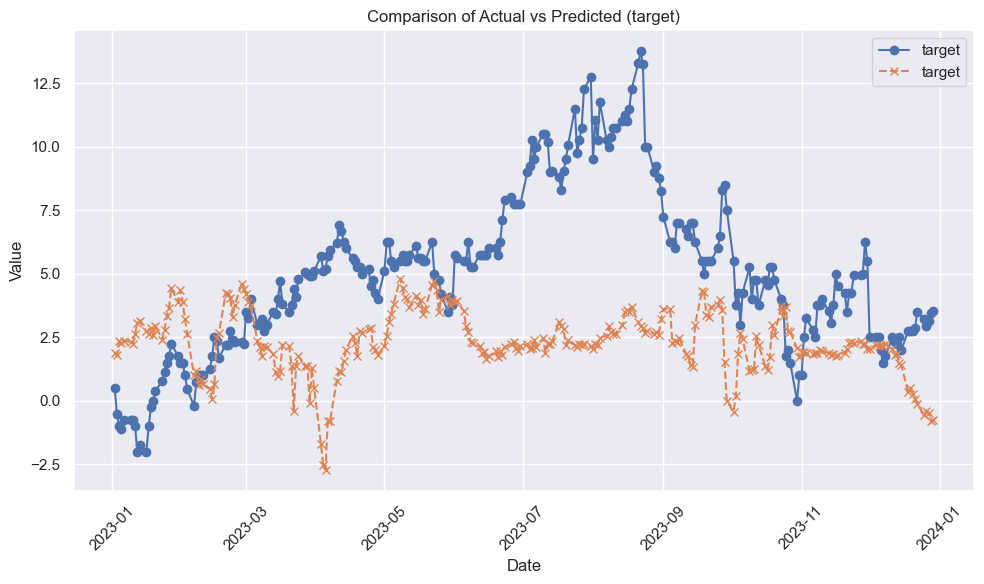

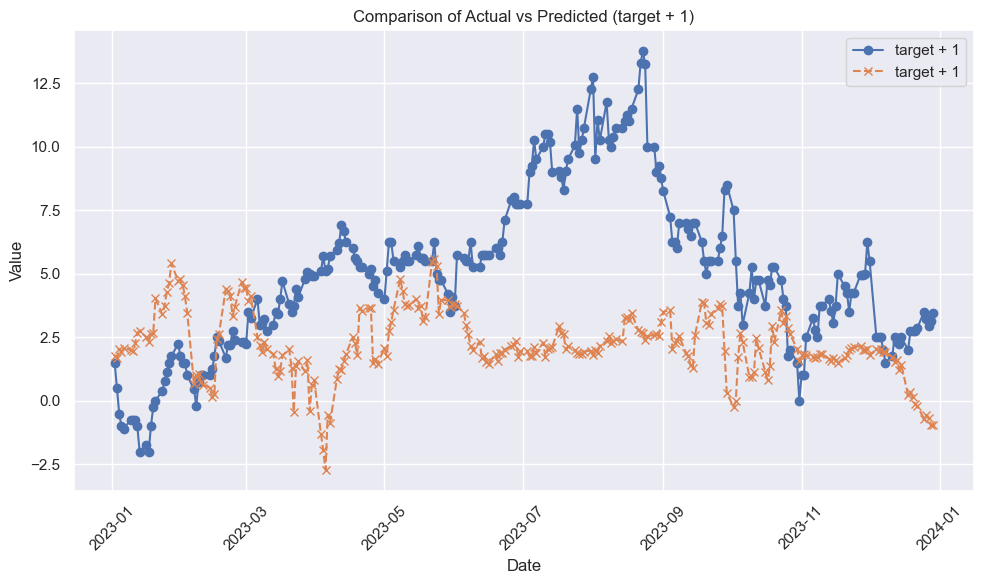

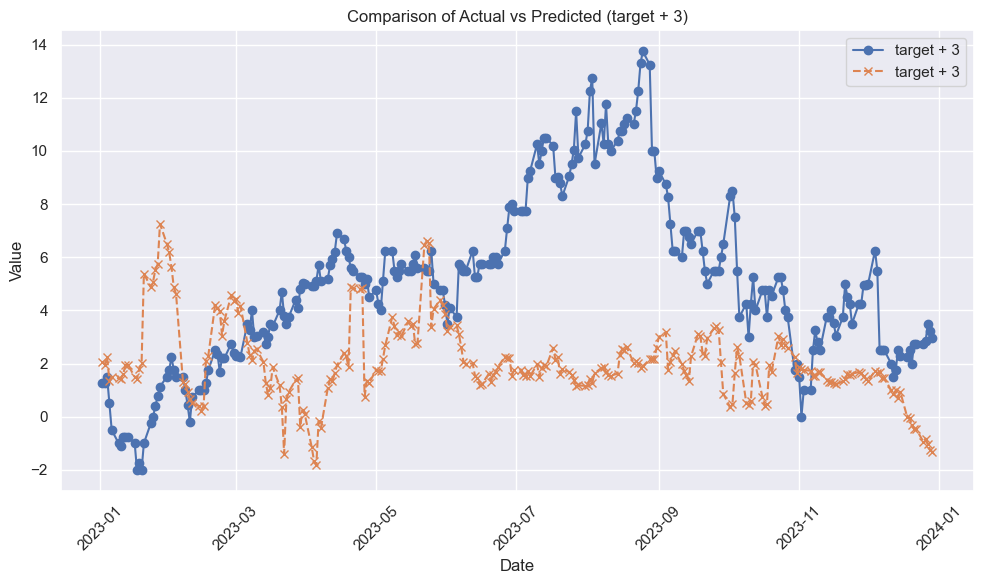

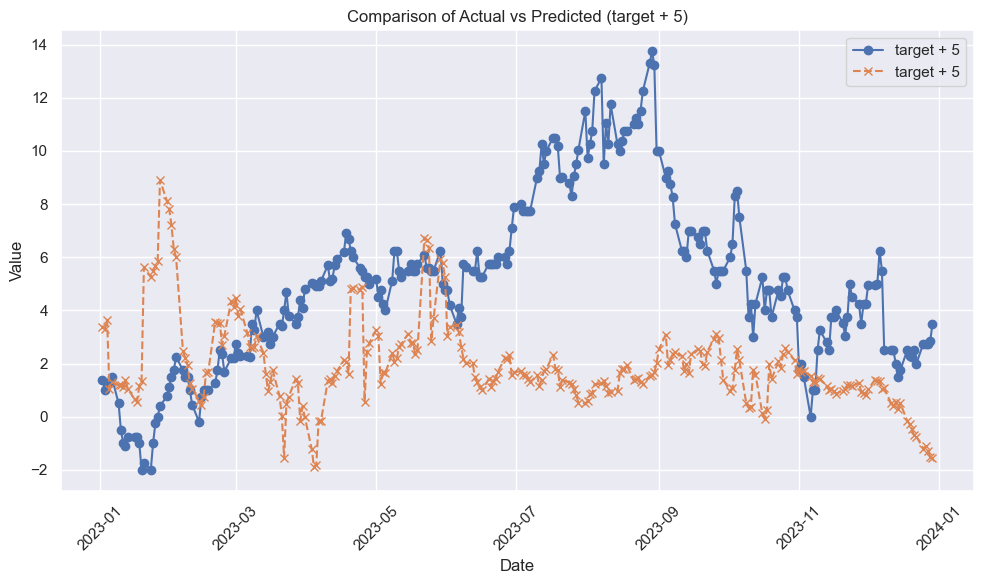

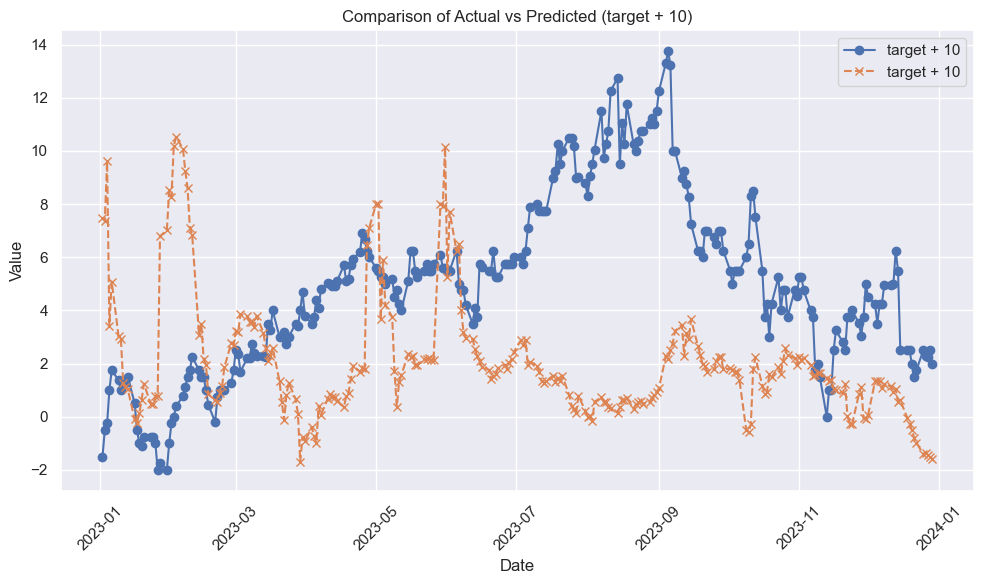

In [86]:
predict(data, targets, '2023-01-01')

# Columns shifted + time-related

In [114]:
data

,ALVARI,ALVARI+1,ALVARI+3,ALVARI+5,ALVARI+10,ARAMCOSG,ARAMCOSG+1,ARAMCOSG+3,ARAMCOSG+5,ARAMCOSG+10,...,_rgp_10_sz_3,_rgp_10_sz_3+1,_rgp_10_sz_3+3,_rgp_10_sz_3+5,_rgp_10_sz_3+10,_rgp_11_sz_3,_rgp_11_sz_3+1,_rgp_11_sz_3+3,_rgp_11_sz_3+5,_rgp_11_sz_3+10
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
dates = pd.DataFrame({'pricing_date': data.index.tolist()})
dates.date = pd.to_datetime(dates.date)

df = dates.copy()
df['year_sin'] = np.sin(df['pricing_date'].dt.year / df['pricing_date'].dt.year.max() * 2 * np.pi)
df['month_sin'] = np.sin(df['pricing_date'].dt.month / df['pricing_date'].dt.month.max() * 2 * np.pi)
df['day_sin'] = np.sin(df['date'].dt.day / df['date'].dt.day.max() * 2 * np.pi)
df['dow_sin'] = np.sin(df['pricing_date'].dt.dayofweek / df['date'].dt.dayofweek.max() * 2 * np.pi)

df['year_num'] = df['date'].dt.year
df['month_num'] = df['date'].dt.month
df['day_num'] = df['date'].dt.day
df['dow_num'] = df['date'].dt.dayofweek
df

AttributeError: 'DataFrame' object has no attribute 'date'

In [109]:
# df.set_index('date', inplace=True)
data = pd.concat([data, df], axis=1)

In [110]:
data

,ALVARI,ALVARI+1,ALVARI+3,ALVARI+5,ALVARI+10,ARAMCOSG,ARAMCOSG+1,ARAMCOSG+3,ARAMCOSG+5,ARAMCOSG+10,...,_rgp_11_sz_3+5,_rgp_11_sz_3+10,year_sin,month_sin,day_sin,dow_sin,year_num,month_num,day_num,dow_num
2017-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-2.449294e-16,-2.449294e-16,-0.937752,0.000000e+00,2023.0,12.0,25.0,0.0
2023-12-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-2.449294e-16,-2.449294e-16,-0.848644,1.000000e+00,2023.0,12.0,26.0,1.0
2023-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-2.449294e-16,-2.449294e-16,-0.724793,1.224647e-16,2023.0,12.0,27.0,2.0
2023-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-2.449294e-16,-2.449294e-16,-0.571268,-1.000000e+00,2023.0,12.0,28.0,3.0
